In [1]:
import pennylane as qml
from pennylane import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
from src.model import convolution_op, pooling_op, fully_connected_op

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

# Data Generation

In [4]:
def generate_dataset(num_images: int, size: int = 4, noise: float = 0.2):
    """Generate a vertical or horizontal line on the grid and then add noise in to it"""
    images = []
    labels = []
    
    for i in range(num_images):
        # Create a blank image
        image = np.zeros((size, size), dtype=np.uint16)
        # Randomly choose a line orientation
        if np.random.rand() > 0.5:
            # Vertical line
            x = np.random.randint(0, size)
            image[:, x] = 255
            labels.append(1)  # Label for vertical line
        else:
            # Horizontal line
            y = np.random.randint(0, size)
            image[y, :] = 255
            labels.append(0)
        
        # Add noise to the image
        noise_matrix = np.random.normal(0, noise * 255, (size, size))
        image = np.clip(image + noise_matrix, 0.0, 255.0)
        images.append(image.astype(np.float32) / 255.0)
    
    return np.array(images), np.array(labels)

In [5]:
images, labels = generate_dataset(50, noise=0.1)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=42
)

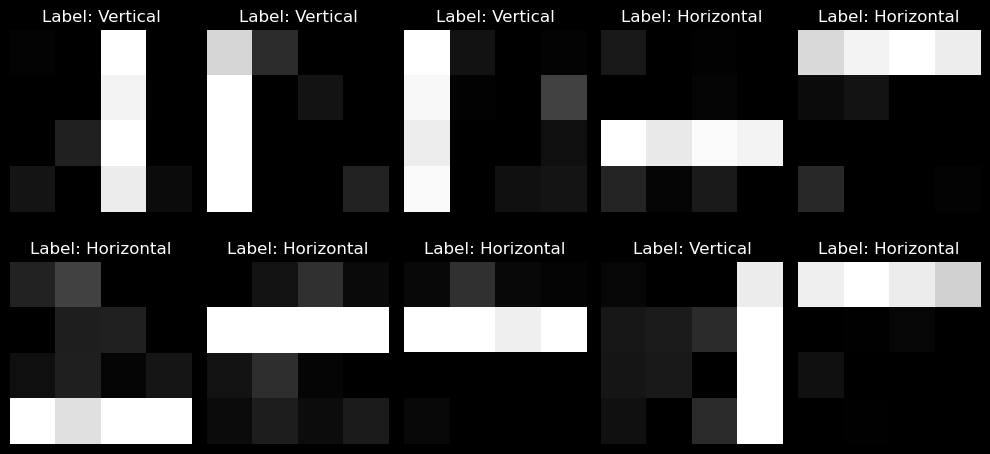

In [6]:
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_images[i].reshape(train_images.shape[1], train_images.shape[2]), cmap='gray')
    plt.title(f"Label: {'Horizontal' if train_labels[i] == 0 else 'Vertical'}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Creating Circuit

In [ ]:
assert train_images.shape[1] == train_images.shape[2], "Images must be square"
N = train_images.shape[1]
dev = qml.device("default.qubit", wires=N * N)
wire_arr = np.arange(N * N).reshape(N, N)

KERNEL_SIZE = 2
KERNEL_LAYERS = 2
STRIDE = 2

In [ ]:
@qml.qnode(dev)
def circuit(phi: np.ndarray):
    # First Convolution Layer
    
    first_kernel = phi[:KERNEL_SIZE * KERNEL_SIZE * KERNEL_LAYERS]
    # for i in range(0, N, KERNEL_SIZE):
    #     for j in range(0, N, KERNEL_SIZE):
    #         convolution_op(
    #             first_kernel,
    #             wire_arr[i:i + KERNEL_SIZE, j:j + KERNEL_SIZE].flatten()
    #         )
    for k in range(0, KERNEL_SIZE, STRIDE):
        for l in range(0, KERNEL_SIZE, STRIDE):
            for i in range(0, N, KERNEL_SIZE):
                for j in range(0, N, KERNEL_SIZE):
                    convolution_op(
                        first_kernel,
                        wire_arr.take(range(i+k,i+KERNEL_SIZE+k),mode='wrap', axis=0).take(range(j+l,j+KERNEL_SIZE+k),mode='wrap',axis=1).flatten()
                    )
    
    first_pooling = phi[KERNEL_SIZE * KERNEL_SIZE * KERNEL_LAYERS:KERNEL_SIZE * KERNEL_SIZE * KERNEL_LAYERS + KERNEL_SIZE]
    for i in range(0, N, KERNEL_SIZE):
        for j in range(0, N, KERNEL_SIZE):
            pooling_op(
                first_pooling,
                wire_arr[i:i + KERNEL_SIZE, j:j + KERNEL_SIZE].flatten()
            )

In [21]:
# demo grabbing top corner

wire_arr.take(range(0,2),mode='wrap', axis=0).take(range(0,2),mode='wrap',axis=1)

tensor([[0, 1],
        [4, 5]], requires_grad=True)